In [25]:
import math
import json
import itertools
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [61]:
def calc_diversity(cov, gene, window):
    #Find diversity among all viruses at each time point
    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'

    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    date_range = meta['year'].max() - meta['year'].min()
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 1
            date_window_start += 1     

    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []

    syn_diversity = []
    nonsyn_diversity = []
        
    for years, subset_viruses in virus_time_subset.items():
        #only use windows with 3 or more viruses
        if len(subset_viruses) >= 3:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))

            #initiate list for all sequences in time window
            sequences = []

            with open(input_file_alignment, "r") as aligned_handle:
                for virus in SeqIO.parse(aligned_handle, "fasta"):
                    #Only viruses in time window
                    if virus.id in subset_viruses:
                        sequences.append(str(virus.seq))
            
            gene_len = len(sequences[0])
            #list for all pairwise diversities
            window_syn_diversity = []
            window_nonsyn_diversity = []
            for pair in itertools.combinations(sequences, 2):
                pairwise_syn_hamming = 0
                pairwise_nonsyn_hamming = 0
                for pos in range(gene_len):
                    if pair[0][pos] != pair[1][pos]:
                        nt0 = pair[0][pos]
                        nt1 = pair[1][pos]
                        
                        codon = math.floor(pos/3)
                        codon_pos = pos-(codon*3)
                        if codon_pos == 0:
                            codon_nt0 = SeqRecord(Seq(pair[0][pos:(pos+3)]))
                            codon_nt1 = SeqRecord(Seq(pair[1][pos:(pos+3)]))
                        elif codon_pos == 1:
                            codon_nt0 = SeqRecord(Seq(pair[0][(pos-1):(pos+2)]))
                            codon_nt1 = SeqRecord(Seq(pair[1][(pos-1):(pos+2)]))
                        elif codon_pos == 2:
                            codon_nt0 = SeqRecord(Seq(pair[0][(pos-2):(pos+1)]))
                            codon_nt1 = SeqRecord(Seq(pair[1][(pos-2):(pos+1)]))
                        codon_aa0 = str(codon_nt0.translate())
                        codon_aa1 = str(codon_nt1.translate())
                        
                        if codon_aa0 != codon_aa1:
                            pairwise_nonsyn_hamming+=1
                        elif codon_aa0 == codon_aa1:
                            pairwise_syn_hamming+=1
                pairwise_syn_diversity = pairwise_syn_hamming/gene_len
                pairwise_nonsyn_diversity = pairwise_nonsyn_hamming/gene_len
                window_syn_diversity.append(pairwise_syn_diversity)
                window_nonsyn_diversity.append(pairwise_nonsyn_diversity)
                
            syn_diversity.append(window_syn_diversity)
            nonsyn_diversity.append(window_nonsyn_diversity)
    
    return year_windows, seqs_in_window, syn_diversity, nonsyn_diversity



In [58]:
def plot_diversity(cov, genes, window):

    data_to_plot = []
    for gene in genes:
        year_windows, seqs_in_window, syn_diversity, nonsyn_diversity = calc_diversity(cov, gene, window)

        for window_index in range(len(year_windows)):
            for virus_syn in syn_diversity[window_index]:
                data_to_plot.append({'year': year_windows[window_index][0:4], 
                                     'gene': gene, 'substitution': 'syn', 
                                     'diversity': virus_syn})
            for virus_nonsyn in nonsyn_diversity[window_index]:
                data_to_plot.append({'year': year_windows[window_index][0:4], 
                                     'gene': gene, 'substitution': 'nonsyn', 
                                     'diversity': virus_nonsyn})
    
    df_to_plot = pd.DataFrame(data_to_plot)

    
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.lineplot(x='year', y='diversity', hue='gene', 
                      style = 'substitution', markers = True, markersize = 20, 
                      data = df_to_plot)
    plt.title(str(cov), fontsize=20)
    ax.tick_params(labelsize=12)
    plt.xlabel('year', fontsize=18)
    plt.ylabel('diversity ', fontsize=18)
    plt.legend(prop={'size': 20})
    
    

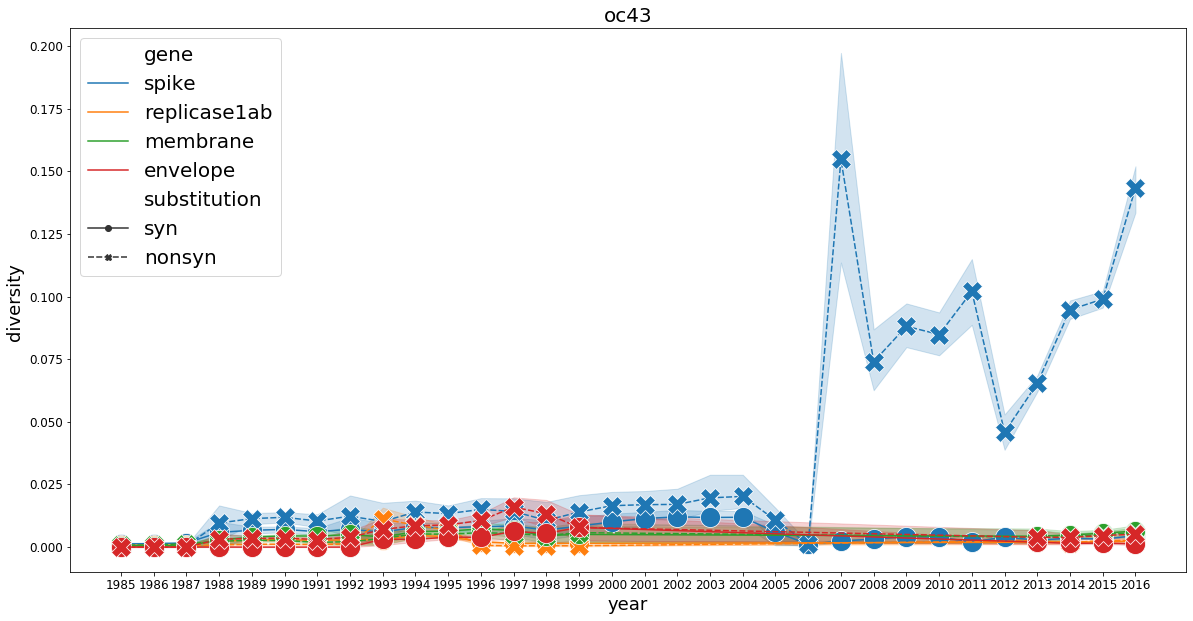

In [62]:
plot_diversity('oc43', ['spike', 'replicase1ab', 'membrane', 'envelope'], 3)

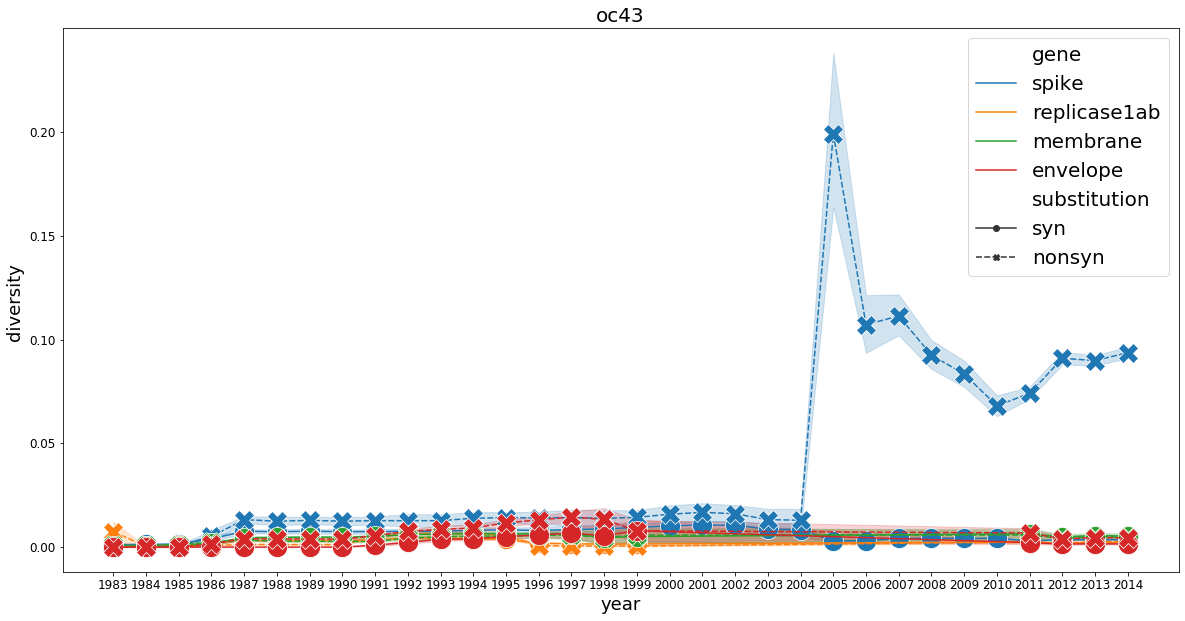

In [64]:
plot_diversity('oc43', ['spike', 'replicase1ab', 'membrane', 'envelope'], 5)

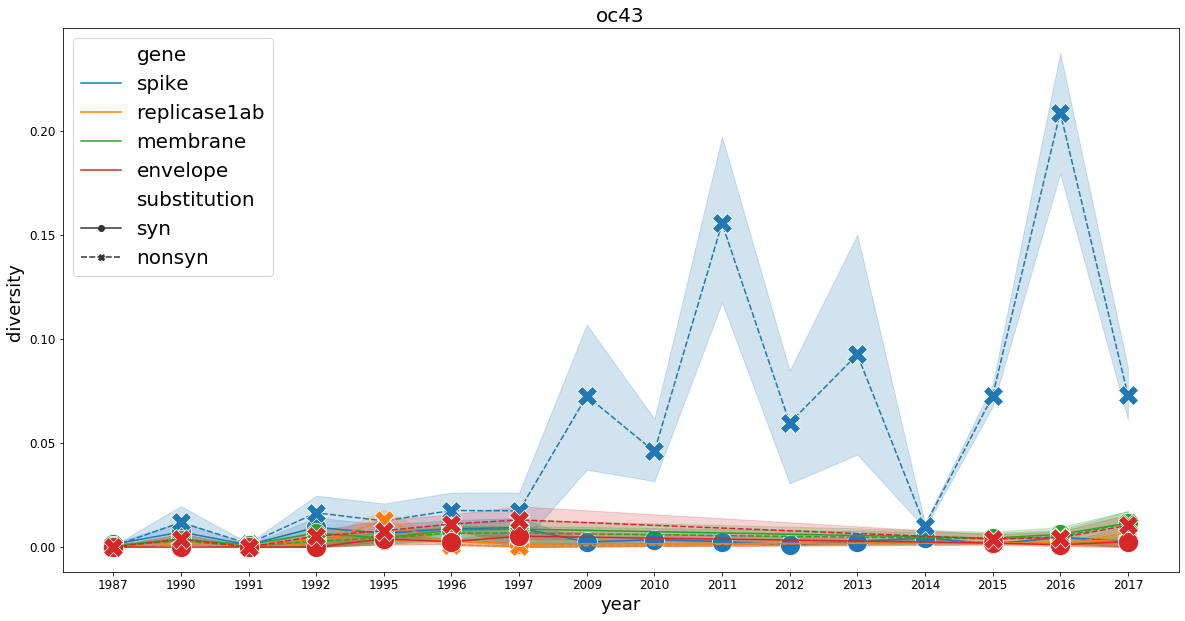

In [65]:
plot_diversity('oc43', ['spike', 'replicase1ab', 'membrane', 'envelope'], 1)

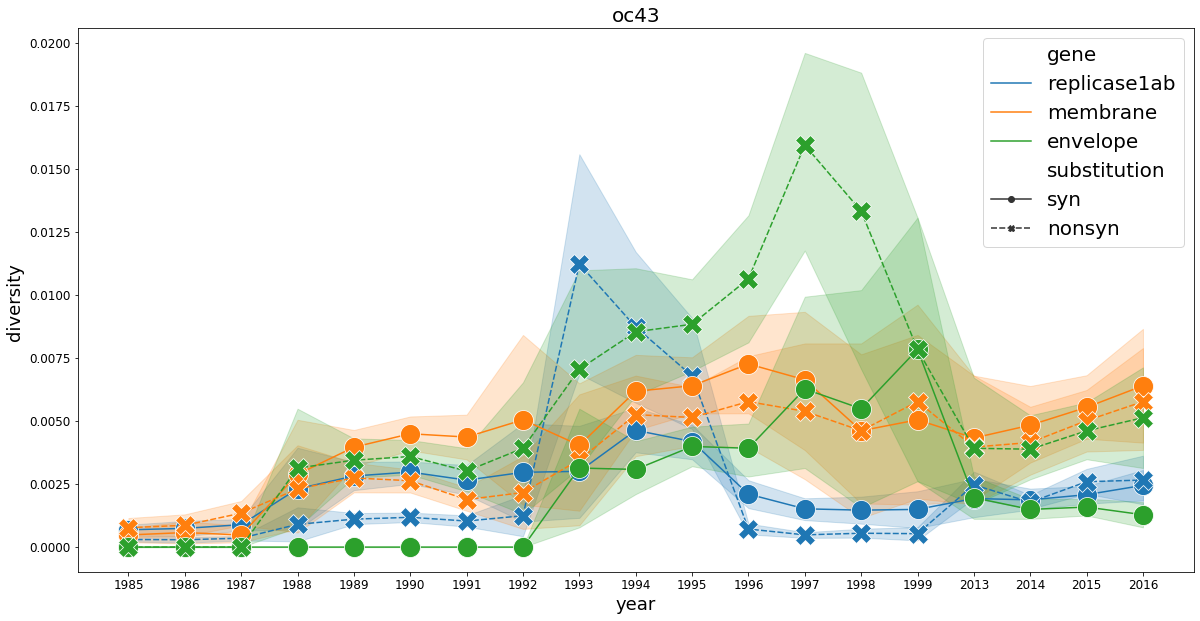

In [63]:
plot_diversity('oc43', ['replicase1ab', 'membrane', 'envelope'], 3)